# Homework 2
### House Prices: Advanced Regression Techniques [Kaggle Competition]
##### Erik Webb

What do you think of when you think of your dream home? Is it a mansion? A cottage? Does it sit on a large lot? Does it have a pool? A fireplace? How much are you willing to pay for that aggregated set of features? This is a project about house prices!

In [1]:
from IPython.display import Image
Image(url= "https://static.pexels.com/photos/106399/pexels-photo-106399.jpeg")

The objective of this Kaggle competition (and assignment) is to create models to predict house prices. The training dataset contains 1460 observations and 80 features. Let's start by calling packages and brining in the data.

In [2]:
# Core Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# ML Packages
from sklearn.linear_model import SGDRegressor, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Other Packages
import missingno as msno

In [3]:
train_location = "/Users/erikgregorywebb/Documents/Python/data/House-Prices-Advanced-Regression/train.csv"
test_location = "/Users/erikgregorywebb/Documents/Python/data/House-Prices-Advanced-Regression/test.csv"

train = pd.read_csv(train_location)
test = pd.read_csv(test_location)

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Right off the bat we'll remove 'SalePrice' and 'Id' from the training dataset and log-transform 'SalePrice', which is our target.

In [5]:
target = train['SalePrice']
target_transformed = np.log(target)

train = train.drop(['SalePrice', 'Id'], axis = 1)

We'll tackle this assignment in three general steps: 
1. Data Cleaning 
2. Data Exploration & Visualization 
3. Model Fitting & Evaluation

Let's get started!

### 1. Data Cleaning 

Before we start cleaning, let's develop a better understanding of what the data looks like.

In [6]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

It looks like we have information about almost every aspect of a home (and its surrounding property) you could imagine, from commonly cited measures like square-feet and number of bedrooms to more detailed  metrics like the height of the basement or the masonry veneer type. Note that the final column is 'SalePrice', which is the variable we seek to predict. 

Below is a categorization of the features within the following buckets: Sales, General, Location, Property, Interior, Basement, Utilities, Garage, and Exterior. This categorization is a subjective exercise, but it allowed me to become more familiar with the features and create general buckets within the dataset.  

**Sale**
- SalePrice: the property's sale price in dollars
- MoSold: Month Sold
- YrSold: Year Sold
- SaleType: Type of sale
- SaleCondition: Condition of sale

**General**
- MSSubClass: The building class
- MSZoning: The general zoning classification
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Overall material and finish quality
- OverallCond: Overall condition rating
- YearBuilt: Original construction date
- YearRemodAdd: Remodel date
- MiscFeature: Miscellaneous feature not covered in other categories
- MiscVal: Dollar Value of miscellaneous feature

**Location**
- Street: Type of road access
- Alley: Type of alley access
- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to main road or railroad
- Condition2: Proximity to main road or railroad (if a second is present)
- LotFrontage: Linear feet of street connected to property

**Property**
- LotArea: Lot size in square feet
- LotShape: General shape of property
- LandContour: Flatness of the property
- LotConfig: Lot configuration
- LandSlope: Slope of property

**Interior**
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)
- GrLivArea: Above grade (ground) living area square feet
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Number of bedrooms above basement level
- Kitchen: Number of kitchens
- KitchenQual: Kitchen quality
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Functional: Home functionality rating
- Fireplaces: Number of fireplaces
- FireplaceQu: Fireplace quality

**Basement**
- BsmtQual: Height of the basement
- BsmtCond: General condition of the basement
- BsmtExposure: Walkout or garden level basement walls
- BsmtFinType1: Quality of basement finished area
- BsmtFinSF1: Type 1 finished square feet
- BsmtFinType2: Quality of second finished area (if present)
- BsmtFinSF2: Type 2 finished square feet
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area
- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms

**Utilities**
- Utilities: Type of utilities available
- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system

**Garage**
- GarageType: Garage location
- GarageYrBlt: Year garage was built
- GarageFinish: Interior finish of the garage
- GarageCars: Size of garage in car capacity
- GarageArea: Size of garage in square feet
- GarageQual: Garage quality
- GarageCond: Garage condition

**Exterior**
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- MasVnrArea: Masonry veneer area in square feet
- ExterQual: Exterior material quality
- ExterCond: Present condition of the material on the exterior
- Foundation: Type of foundation
- PavedDrive: Paved driveway
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet
- PoolQC: Pool quality
- Fence: Fence quality

Note that these features are a mix of continuous (Lot Area, Year Built, Bedrooms) and categorical (House Style, Roof Style, Garage Type) variables. 

Let's start cleaning by checking for missing values. Below we find the number of missing values for each feature, for features with missing values. 

In [7]:
# Find the number of missing values for each feature, including only those greater than 0. 
missing_values = pd.DataFrame(train.isnull().sum())
missing_values = missing_values[(missing_values > 0).any(axis=1)]

# Sort the values in ascending order. 
missing_values = missing_values.sort_values(by = 0, ascending = False)
missing_values.columns = ['Number of Missing Values']

# Calculate 'Percent Missing'
missing_values['Percent Missing'] = missing_values['Number of Missing Values']/len(train)
missing_values

,Number of Missing Values,Percent Missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


19 of the 80 features are missing 1 or more value. However, the degree to which values are missing varies widely across the 19 variables. Only 7 of the 1460 properties have information about pool quality ('PoolQC') while only 1 property is missing information about the property's electrical system! I leveraged a packaged called [missingno]("https://github.com/ResidentMario/missingno") to better understand and help visualize the missing data. Due to the large number of features, I divided the data into two visuals:

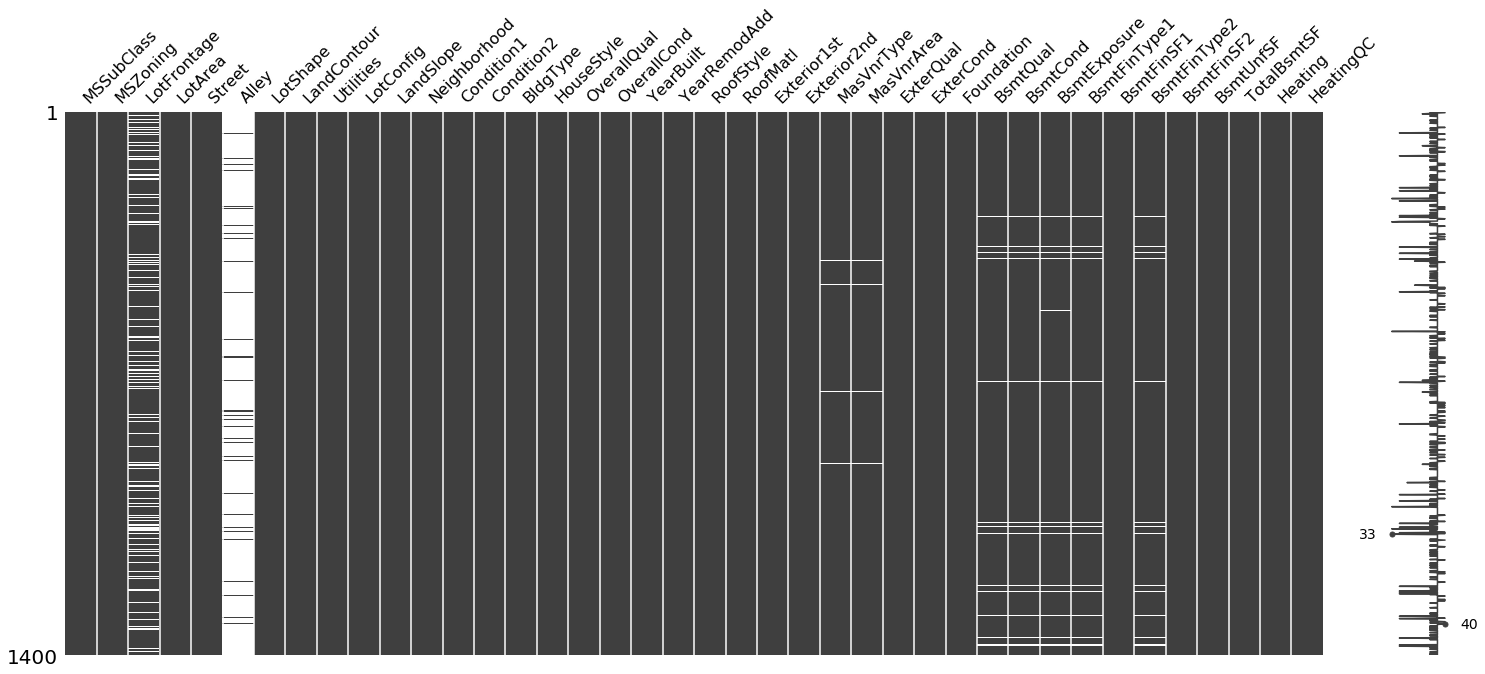

In [8]:
# First 41 Features
msno.matrix(train.iloc[:,0:40].sample(1400))

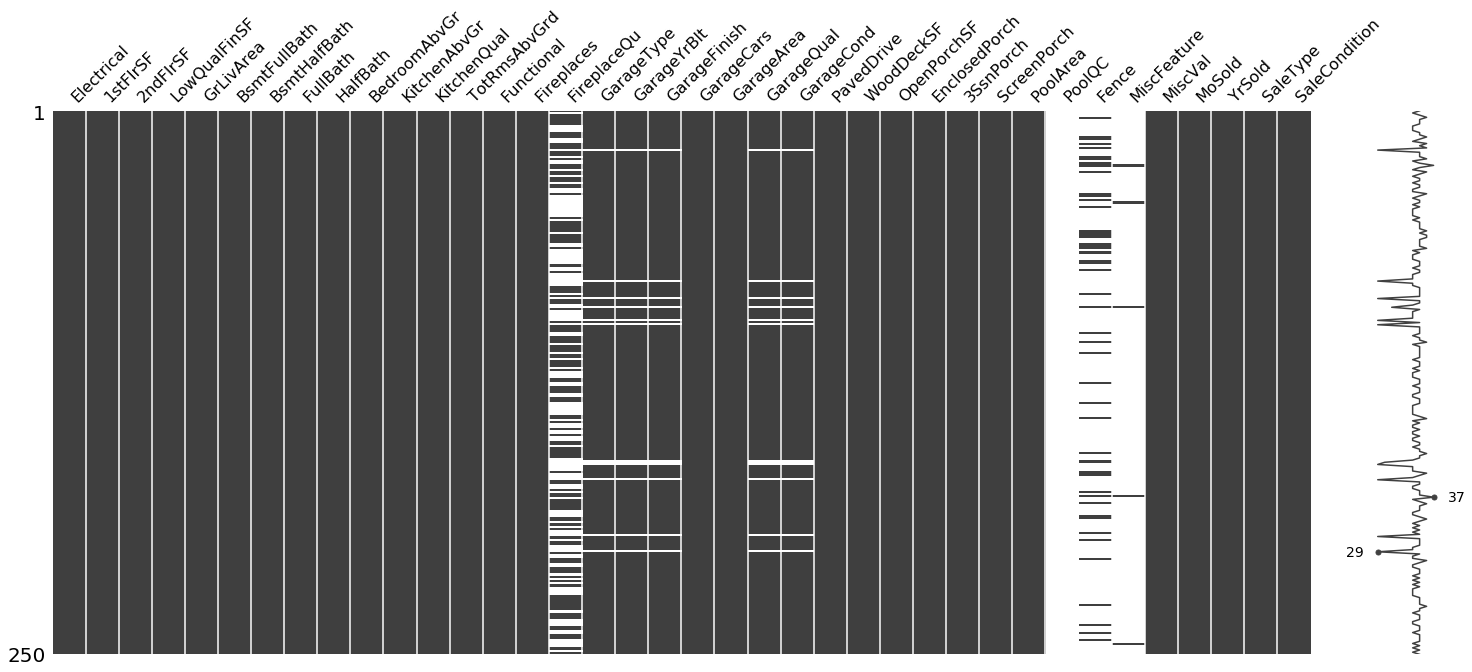

In [9]:
# Remaining Features
msno.matrix(train.iloc[:,41:81].sample(250))

Based on this exercise, we'll drop 'Alley', 'FireplaceQu', 'PoolQC', 'PoolArea', 'Fence', and 'MiscFeature' from our dataset. 

In [10]:
train = train.drop(['MiscFeature', 'Fence', 'PoolQC', 'PoolArea', 'FireplaceQu', 'Alley'], axis = 1)

What about the others? Let's fill them in with the average of the feature if the feature is continuous or with the mode if the feature is categorical. 

In [11]:
for feature in train:
   # Features with a 'dtype' of O are categorical 
    if train[feature].dtype == 'O':
       train[feature] = train[feature].fillna(train[feature].mode()[0])

for feature in train:
   # Features with a 'dtype' of i or are floats are continuous
    if train[feature].dtype == np.float64 or train[feature].dtype == 'i':
       train[feature] = train[feature].fillna(train[feature].mean())

Let's confirm there aren't any remaining missing values.

In [12]:
# Should return 'False'
train.isnull().any().any()

False

What's next? Outliers! To start we'll explicitly determine which of our features are categorical and which are continuous.

In [13]:
# Create two empty lists
continuous_features = []
categorical_features = []

# Seperate features by dtype
for feature in train.columns:
    if train[feature].dtype == "object":
        categorical_features.append(feature)
    else:
        continuous_features.append(feature)
        
print("Number of Continuous Features:", len(continuous_features), "\nNumber of Categorical Features:", len(categorical_features))

Number of Continuous Features: 35 
Number of Categorical Features: 38


We'll use this to filter outliers according to a simple rule: 

For each column we compute the z-score of each value in the column relative to the column mean and standard deviation. Since the direction of the difference is irrelevant, we take the absolute value. Here we remove rows that contain a (continuous) feature value greater than 5 standard deviations away the standardized mean. 

This code below was adapted from [this](https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe) Stack Overflow article.

In [14]:
n_std = 5
len(train) - len(train[train[continuous_features].apply(lambda x: np.abs(x - x.mean()) / x.std() < n_std).all(axis=1)])

86

In doing so we drop 86 rows of our training data. We can adjust this threshold later to see if it affects our mean squared error.

In [15]:
# Drop rows in training set (and target) according to the rule described above
target_transformed = target_transformed[train[continuous_features].apply(lambda x: np.abs(x - x.mean()) / x.std() < 10).all(axis=1)]
train = train[train[continuous_features].apply(lambda x: np.abs(x - x.mean()) / x.std() < 10).all(axis=1)]

The final step of the cleaning process is to create dummy variables for the categorical features. We'll also apply the changes we've made to the test dataset. 

In [16]:
train_no_dummies = train
train = pd.get_dummies(train)

In [17]:
test = test.drop(['MiscFeature', 'Fence', 'PoolQC', 'FireplaceQu', 'Alley'], axis = 1)

for feature in test:
    # Features with a 'dtype' of O are categorical 
   if test[feature].dtype == 'O':
       test[feature] = test[feature].fillna(test[feature].mode()[0])
for feature in test:
    # Features with a 'dtype' of i or are floats are continuous
    if test[feature].dtype == np.float64 or test[feature].dtype == 'i':
       test[feature] = test[feature].fillna(test[feature].mean())
        
test = pd.get_dummies(test)

# Only keep columns in test that are also found in train
test = test.reindex(columns = train.columns, fill_value=0)

### 2. Data Exploration & Visualization 

With the data cleaned we're now ready to explore it! 

Let's calculate the correlations for all of the continuous features and rank them from -1 to 1.

In [18]:
# Filter out categorical variables
values = []
df = train[continuous_features]

# Iterate over each continous feature and calcualte its correlation with the target
for feature in df.columns:
    values.append([feature, df[feature].corr(target_transformed)])
    
# Sort the values and present them in a Pandas Dataframe
values = sorted(values, key=lambda x: x[1])
correlations = pd.DataFrame(values, columns = ['Feature', 'Correlation with SalePrice'])
correlations

,Feature,Correlation with SalePrice
0,KitchenAbvGr,-0.152188
1,EnclosedPorch,-0.144739
2,MSSubClass,-0.075204
3,MiscVal,-0.052795
4,OverallCond,-0.047424
5,LowQualFinSF,-0.046792
6,YrSold,-0.035748
7,BsmtHalfBath,-0.007559
8,BsmtFinSF2,-0.001445
9,3SsnPorch,0.054411


Nice! It looks like 'OverallQual', 'GrLivArea' 'GarageCars', 'GarageArea', 'TotalBsmtSF' and '1stFlrSF' are moderately to highly correlated with 'SalePrice'. Who would have know the garage mattered so much! We'll have to examine the coefficients on these features when we do model fitting later on.

To simplify and expedite the exploration process I created a function to describe and visualize features depending on if they are continuous or categorical in nature:

In [19]:
def describe_feature(feature, dataframe):
    print(feature)
    # Determine the data type of the feature
    if dataframe[feature].dtype == "object":
        # Create a boxplot of the categorial feature against the target
        sns.boxplot(x=dataframe[feature], y=target_transformed, data=dataframe)
        plt.pause(0.05)
    else:
        # Create a scatterplot of the continuous feature with the target
        # Assign a random color to the plot for diversity (and fun)
        sns.regplot(x=dataframe[feature], y=target_transformed, data=dataframe, color = np.random.rand(3,))
        plt.pause(0.05)

We'll create scatter plots for the features previously mentioned as having moderate to high correlation with the target, 'SalePrice'. 

1stFlrSF


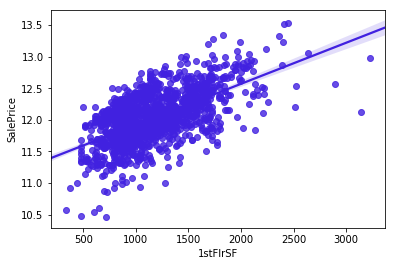

TotalBsmtSF


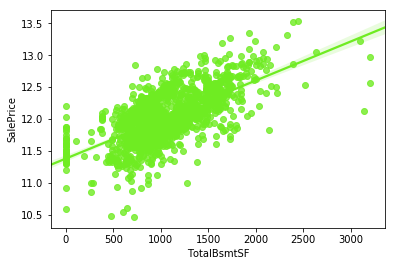

GarageArea


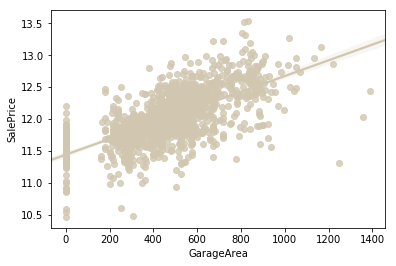

GarageCars


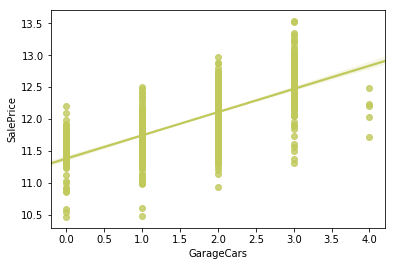

GrLivArea


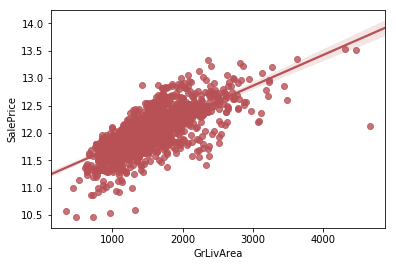

OverallQual


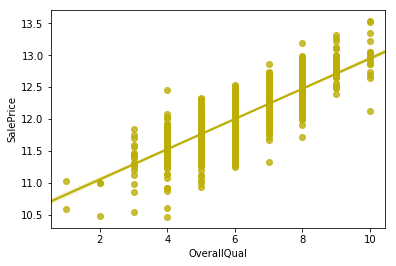

In [20]:
# Plot the top 6 most highly correlated (with the target) features
high_corr = list(correlations['Feature'])[-6:]
for feature in high_corr:
    describe_feature(feature, train)

As expected, these features appear to have a fairly strong, linear relationship with 'SalePrice'. Now let's try out the same function with a few of the categorical variables!

MSZoning


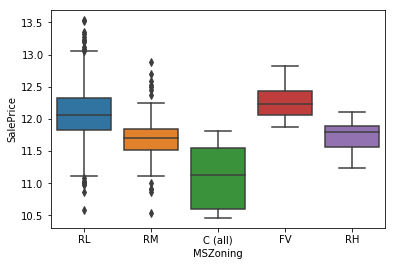

Street


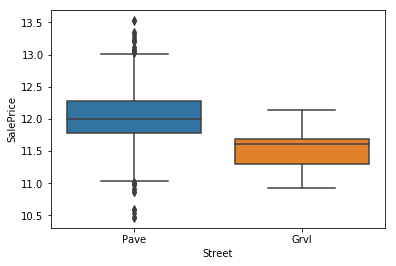

LotShape


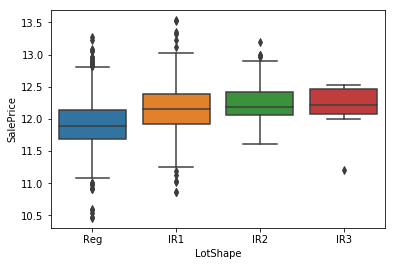

LandContour


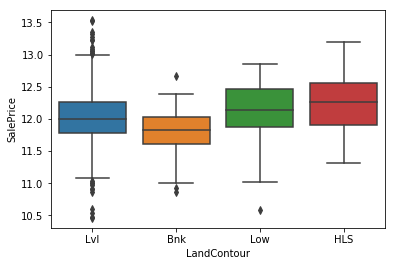

Utilities


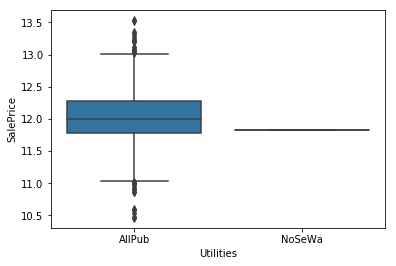

In [21]:
# Plot several boxplots of categorical features
for feature in train_no_dummies.columns[0:8]:
    if train_no_dummies[feature].dtype == "object":
        describe_feature(feature, train_no_dummies)

For categorical features I usually hope to see variation across the levels (or factors) of the feature. This means that the feature will likely be useful in predicting the sales price of the home. This seems to be generally true for the small sample of categorical variables shown above.

### 3. Model Fitting & Evaluation

I begin the modeling stage of the assignment by creating a baseline model, something that we can compare the results of more complicated models to. Here I adapt the [code](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_4_Linear_Regression_and_Evaluation.ipynb) shared in lecture.

We begin by scaling the training and test data and confirming that the matrices have the correct shape.

In [22]:
# Scale the training data
scaler = StandardScaler()
scaler.fit(train)
scaled_train_df = scaler.transform(train)

# Scale the test data
scaler.fit(test)
scaled_test_df = scaler.transform(test)

In [23]:
# The training and test sets should have the same number of columns
print(target_transformed.shape, scaled_train_df.shape, scaled_test_df.shape)

(1443,) (1443, 267) (1459, 267)


#### Basic Linear Regression

What conditions are assumed to be satisfied in the linear regression framework? This [article](http://people.duke.edu/~rnau/testing.htm) produced by Duke summarizes these assumptions: 
1. Linearity of relationship between dependent and independent variables.
2. No serial correlation between error terms.
3. Homoscedasticity (constant variance of the errors)
4. Errors are normally distributed.

As we've discussed in class, machine learning as a field has historically been more interested in a model's **predictive ability** as opposed to its ability to satisfy assumptions. The opposite is likely true in the field of econometrics. Nevertheless, we'll visually explore a few of the assumptions in just a minute. 

First, let's fit a 'kitchen-sink' linear model, which includes all possible features.

In [24]:
# Fit the model
basic_linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
basic_linear_regression_model.fit(scaled_train_df, target_transformed)

# Calculate the MSE
predictions = basic_linear_regression_model.predict(scaled_train_df)
mse = mean_squared_error(target_transformed, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 25.907271406972136


Tadaa! Our first model! Note that we passed parameters to SGDRegressor telling it the initial learning rate and when to stop iterating, formally called the convergence criteria. 

Now let's check out some of those assumptions we mentioned earlier. We'll check for homoscedasticity and if the errors are normally distributed.

Text(0.5,1,'Homoscedasticity Check: Residuals Plotted Against TotalBsmtSF')

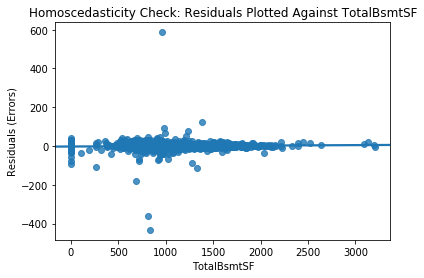

In [25]:
# Check for homoscedasticity assumption of linear model 
# by plotting calculated residuals against TotalBsmtSF 
sns.regplot(train['TotalBsmtSF'], predictions - target_transformed)
plt.ylabel("Residuals (Errors)")
plt.title("Homoscedasticity Check: Residuals Plotted Against TotalBsmtSF")

Text(0.5,1,'Distribution of Error Terms')

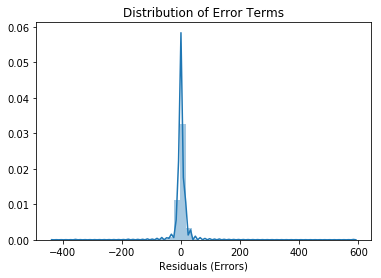

In [26]:
# Check for normality of error terms by creating a histogram of calculated residuals
sns.distplot(predictions - target_transformed, axlabel = "Residuals (Errors)", label = "Test")
plt.title("Distribution of Error Terms")

What do you think? There doesn't appear to be a relationship between the residuals and the feature 'TotalBsmtSF'. In other words, the value of any given residual does not depend on the level of that feature. Note that this should be true for all features! I only visualized the 'TotalBsmtSF' feature. 

It looks like most of the density of the error term distribution is centered around zero, although it appeared to be strongly skewed. With these results in mind, we should proceed with some cation, understanding that some assumption of the linear model may be partially violated.

Let's continue by fitting some more sophisticated models.

#### Linear Regression with Train/Test Split

Above we fit the model using all of the training data. Let's now turn to a train/test split method to see if we can improve! Below we use the same (arbitrary) learning rate parameters as before, but we split the original training dataset into training and test datasets. 

Why are we doing this? It has to do with over-fitting and bias. I think the image below does a good job of summarizing these concepts.

In [27]:
Image(url= "https://i.stack.imgur.com/t0zit.png")

Over-fitting is when a model doesn't generalize well and performs much better on the training set than the test set. A model with high bias isn't fit well on the data. When this happens both the train and test MSE are high. 

The train/test split is a method to avoid the issue of over-fitting. Below we perform the split and fit another model. 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train_df, target_transformed, test_size=0.33, random_state=42)

In [29]:
split_linear_regression_model = SGDRegressor(tol=.0001, eta0=.01)
split_linear_regression_model.fit(X_train, y_train)

# Predict target values for the training and test sets
train_predictions = split_linear_regression_model.predict(X_train)
test_predictions = split_linear_regression_model.predict(X_test)

# Calculate the mse for the training and test sets
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Train MSE: 784.8991481142808
Test MSE: 172.02888032711164


Here the mean square error is actually worse than before. This may have been the result of an odd split with the data, where the training set happened to have outlier-type cases that the test set did not have. 

Let's move from train/test splitting to cross validation.

#### Linear Regression with Cross Validation

In cross validation, all models are trained on a training set and then tested on a validation set. We then take the model that performs best on the validation set and see how well it does on a testing set. This way, we're able to examine how well the model performs with data it's never seen before. It allows us to test multiple models and test different model parameters.

Notice that we supply a ['distribution'](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) or list of parameters to try. With 'n_iter_search' I've specified that 10 parameter settings should be sampled.

In [30]:
# Specify a list of parameters for cross validation
param_dist = {"eta0": [ .001, .003, .01, .03, .1, .3, 1, 3], "tol": [.00001, .0001, .001, .01, .1]}
n_iter_search = 10

# Perform cross validation and fit the model
cross_linear_regression_model = SGDRegressor()
cross_random_search = RandomizedSearchCV(cross_linear_regression_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=3, scoring='neg_mean_squared_error')
cross_random_search.fit(X_train, y_train)

print("Best Parameters: {}".format(cross_random_search.best_params_))
print("Best Negative MSE: {}".format(cross_random_search.best_score_))

Best Parameters: {'tol': 0.0001, 'eta0': 0.003}
Best Negative MSE: -5.134379447146837


Great! It looks like the best parameters are 'tol' = 0.00005 and 'eta0' = 0.001. It also looks like we've improved our MSE, which is a great sign. 

#### Regularized Linear Models (Lasso, Ridge, Elastic Net)

Let's now try regularization! The basic of idea of regularization is to add a penalty to the cost function so that the model doesn't learn complex relationships or form large coefficients. This is a key way to avoid the problem of over-fitting. 

We'll try Lasso, Ridge, and Elastic-Net models. Scikit-learn makes this incredibly easy. Before we fit these models, let's quickly review the difference between them. 
- Lasso (L1): Modify the cost function by adding the sum of the *absolute* values of the coefficients
- Ridge (L2): Modify the cost function by adding the sum of the *squared* values of the coefficients
- Elastic-Net: Do both things by choose how to weight each method. 

Below for the lasso and ridge model we supply five values of alpha for cross validation purposes. Alpha is a parameter which determines the penalty applied to the model for having large coefficients.

In [31]:
# Each of the code chunks below follows the same basic pattern:
# Perform cross validation, fit the model, make predictions, print the best parameters and MSE

# Lasso
lasso = linear_model.Lasso()
lasso_gridsearch = GridSearchCV(lasso, {"alpha": [.1, .3, .5, .7, .9]})
lasso_gridsearch.fit(X_train, y_train)
train_predictions = lasso_gridsearch.predict(X_train)
test_predictions = lasso_gridsearch.predict(X_test)
print("Lasso:")
print("Best Parameters: {}".format(lasso_gridsearch.best_params_))
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)), "\n")

# Ridge
ridge = linear_model.Ridge()
ridge_gridsearch = GridSearchCV(ridge, {"alpha": [.1, .3, .5, .7, .9]})
ridge_gridsearch.fit(X_train, y_train)
train_predictions = ridge_gridsearch.predict(X_train)
test_predictions = ridge_gridsearch.predict(X_test)
print("Ridge:")
print("Best Parameters: {}".format(ridge_gridsearch.best_params_))
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)), "\n")

# Elastic Net
# The values for 'l1_ratio' were the values recommended in the scikit-learn docs
clf_en = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10])
clf_en.fit(X_train, y_train)
train_predictions = clf_en.predict(X_train)
test_predictions = clf_en.predict(X_test)
print("Elastic Net:")
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))

Lasso:
Best Parameters: {'alpha': 0.1}
Train MSE: 0.04304164324933985
Test MSE: 0.047675655637443505 

Ridge:
Best Parameters: {'alpha': 0.9}
Train MSE: 0.006830458562406108
Test MSE: 0.023593825290262545 

Elastic Net:
Train MSE: 0.011734757227167197
Test MSE: 0.020061574356092116


Wow! Now we're really getting somewhere! Note the reduction in the MSE when compared to our previous models. The elastic-net model narrowly edged out the ridge model in terms of the test MSE. Looks like a winner! 

Let's take a minute for model interpretation. What variables are important? 

In [32]:
# Fit another model (without GridSearchCV in order to extract coefficients)
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, y_train)

# Store the important coefficients (only the bottom 7 are non-zero)
coef = pd.Series(lasso.coef_, index = train.columns)
important_coef = coef.sort_values(ascending = True).tail(7)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables!")

Lasso picked 7 variables and eliminated the other 260 variables!


Holy cow! This lasso model eliminated over 97% of the features in the training set. This is actually a reason that people prefer to use Lasso. It can push coefficient all the way to zero and select only those features that really 'matter'. Survival of the fittest! 

The last line in the code chunk above was taken directly from [this](https://www.kaggle.com/apapiu/regularized-linear-models) kernel written by Alexandru Papiu. 

We're dying to know: What were the features that survived?

Text(0.5,1,'Surviving Coefficients: Lasso Model')

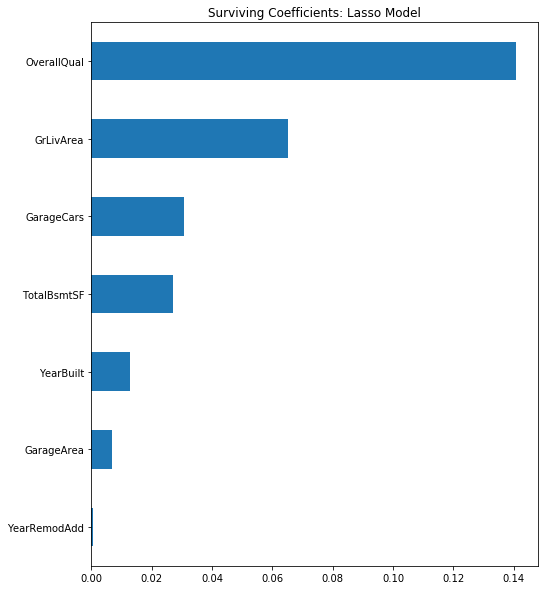

In [33]:
# Create a bar chart with the important coefficients
plt.rcParams['figure.figsize'] = (8.0, 10.0)
important_coef.plot(kind = "barh")
plt.title("Surviving Coefficients: Lasso Model")

It looks like 'OverallQual' is the most important feature (according to this Lasso model), followed by 'GrLiveArea' and 'GarageCars'. I'm surprised that the model eliminated so many features and that none of the surviving features have a negative sign. 

Before we submit our model predictions, let's experiment with a few more models. It's exciting how easy it is to implement machine learning algorithms with Scikit-learn. We'll finish with SVM, K-Nearest Neighbors, Random Forest. 

#### SVM

SVM is classification algorithm but a version of SVM for regression was proposed in 1996. Let's try it out!

In [34]:
# SVM
reg = SVR()
svm_gridsearch = GridSearchCV(reg, {"C": [.1, .3, .5, .7, .9], "epsilon": [.2, .4, .6, .8]}, scoring='neg_mean_squared_error')
svm_gridsearch.fit(X_train, y_train)

train_predictions = svm_gridsearch.predict(X_train)
test_predictions = svm_gridsearch.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Best Params: {}".format(svm_gridsearch.best_params_))
print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))

Best Params: {'C': 0.9, 'epsilon': 0.2}
Train MSE: 0.014459286310671
Test MSE: 0.050580495035214446


#### K-Nearest Neighbors

Although this algorithm is more commonly used for classification problems, it can also be used for regression. It's relatively straightforward. We define the hyper-parameter k and define a distance metric (usually Euclidean distance). Predicting a new data point is a matter of finding the nearest training points and voting to get a predicted class. Note that k is a hyper-parameter and cross-validation can be used to find the 'optimal' value.

In [35]:
reg = KNeighborsRegressor()
neigh_gridsearch = GridSearchCV(reg, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='neg_mean_squared_error')
neigh_gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(neigh_gridsearch.best_params_))
y_pred_train = neigh_gridsearch.predict(X_train)
y_pred_test = neigh_gridsearch.predict(X_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Train MSE: 0.0	Test MSE: 0.037688213777479836


The train MSE is 0 so its very likely that the model is over-fit. Let's finish with a random forest.  

#### Random Forest

Random Forest models are ensemble models, meaning that they are made up of a collection (or  'forest') of decisions trees. By assembling a large group of 'weak' models we can actually achieve a stronger predictive model. Let's see if that holds true.

In [36]:
# Random Forest
regr = RandomForestRegressor()
rf_gridsearch = GridSearchCV(regr, {"n_estimators": [250, 500, 750], "max_depth": [15, 20, 25, 30]} , scoring='neg_mean_squared_error')
rf_gridsearch.fit(X_train, y_train)

print("Best Params: {}".format(rf_gridsearch.best_params_))
y_pred_train = rf_gridsearch.predict(X_train)
y_pred_test = rf_gridsearch.predict(X_test)
print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))

Best Params: {'max_depth': 20, 'n_estimators': 250}
Train MSE: 0.0027624991650386757	Test MSE: 0.02189605946528068


### Conclusion + Submit Predictions to Kaggle

What a ride! We've tested 8 models each with many possible hyper-parameters. The best model I found was an elastic-net model with a test MSE of 0.02006. I've learned and noticed a few things along the way.

The biggest improvement in MSE came by means of cross-validation. Once we started using cross-validation, the results across the various models used were somewhat comparable. In order to take these models to the next level and improve predictive ability I suspect I would need to return to the training data and make changes there instead of tweaking the models. 

Is the elastic-net model useful? Most likely. Is it perfect? No, but no model is. Would I feel comfortable recommending this/these model(s) to a company like Zillow? Sure, but I would be interested in paying closer attention to outliers and feature engineering.

I'll finish this assignment by exporting csv files for submission to Kaggle. As of my last submission, I ranked 1623 out of 4070 participants, with a log MSE of 0.13227. Thanks for reading! 

In [37]:
# Export predictions from each of the models
models = ['basic_linear_regression_model', 'split_linear_regression_model', 
          'cross_random_search', 'lasso_gridsearch', 'ridge_gridsearch', 'clf_en', 
          'svm_gridsearch', 'neigh_gridsearch', 'rf_gridsearch']
test_submission = pd.read_csv(test_location)

In [38]:
# split_linear_regression_model
y_pred = np.exp(split_linear_regression_model.predict(scaled_test_df))
submission_split_linear_regression_model = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_split_linear_regression_model.to_csv('submission_model_1.csv', sep=',')

# cross_random_search
y_pred = np.exp(cross_random_search.predict(scaled_test_df))
submission_cross_random_search = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_cross_random_search.to_csv('submission_model_2.csv', sep=',')

# lasso_gridsearch
y_pred = np.exp(lasso_gridsearch.predict(scaled_test_df))
submission_lasso_gridsearch = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_lasso_gridsearch.to_csv('submission_model_3.csv', sep=',')

# ridge_gridsearch
y_pred = np.exp(lasso_gridsearch.predict(scaled_test_df))
submission_lasso_gridsearch = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_lasso_gridsearch.to_csv('submission_model_4.csv', sep=',')

# clf_en
y_pred = np.exp(clf_en.predict(scaled_test_df))
submission_clf_en = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_clf_en.to_csv('submission_model_5.csv', sep=',')

# svm_gridsearch
y_pred = np.exp(svm_gridsearch.predict(scaled_test_df))
submission_svm_gridsearch = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_svm_gridsearch.to_csv('submission_model_6.csv', sep=',')

# neigh_gridsearch
y_pred = np.exp(neigh_gridsearch.predict(scaled_test_df))
submission_neigh_gridsearch = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_neigh_gridsearch.to_csv('submission_model_7.csv', sep=',')

# rf_gridsearch
y_pred = np.exp(rf_gridsearch.predict(scaled_test_df))
submission_rf_gridsearch = pd.DataFrame({'Id': list(test_submission['Id'].astype(int)), 'SalePrice': list(y_pred)})
submission_rf_gridsearch.to_csv('submission_model_8.csv', sep=',')

Helpful Links:
- https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-dataframe
- https://stackoverflow.com/questions/29530232/python-pandas-check-if-any-value-is-nan-in-dataframe
- https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Seaborn_Cheat_Sheet.pdf